In [95]:
# --- Make local package importable (robust for notebooks in subfolders) ---
import sys
from pathlib import Path

def add_src_to_path(pkg="quantlib", levels_up=3):
    here = Path.cwd().resolve()
    candidates = [here / "src"]
    # also check parents: ../src, ../../src, ...
    for i in range(1, levels_up+1):
        candidates.append(here.parents[i-1] / "src")
    for p in candidates:
        if (p / pkg / "__init__.py").exists():
            sys.path.insert(0, str(p))
            print(f"[OK] Added to sys.path: {p}")
            return p
    raise FileNotFoundError("Could not find src/quantlib/__init__.py relative to this notebook.")

add_src_to_path()


# 1) Make sure *your* src is first on sys.path
sys.path.insert(0, str(pathlib.Path.cwd() / "src"))

# 2) Invalidate caches and force a fresh import
importlib.invalidate_caches()
import quantlib.risk as qrisk
qrisk = importlib.reload(qrisk)

# 3) Sanity checks
print("Loaded from:", qrisk.__file__)
print("Has func?", hasattr(qrisk, "garch11_forward_like_ewma"))
print([n for n in dir(qrisk) if "garch" in n.lower()])



[OK] Added to sys.path: C:\Users\quantbase\Desktop\quant\src
Loaded from: C:\Users\quantbase\Desktop\quant\src\quantlib\risk.py
Has func? True
['_garch11_from_raw', '_garch11_nll', 'fit_garch11_normal', 'garch11_forecast_path', 'garch11_forward_like_ewma']


In [96]:
# --- bootstrap & imports ---
import sys, pathlib; sys.path.append(str(pathlib.Path.cwd() / "src"))
from pathlib import Path
import numpy as np, pandas as pd
from quantlib import risk as qrisk
from quantlib import viz as qviz
DATA_INT = Path(r"C:\Users\quantbase\Desktop\quant\data_int")
FIG_DIR = Path(r"C:\Users\quantbase\Desktop\quant\figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)


In [97]:
# --- load portfolio returns (or pick a symbol series instead) ---
r_port = pd.read_pickle(DATA_INT/"portfolio_returns.pkl").sort_index()


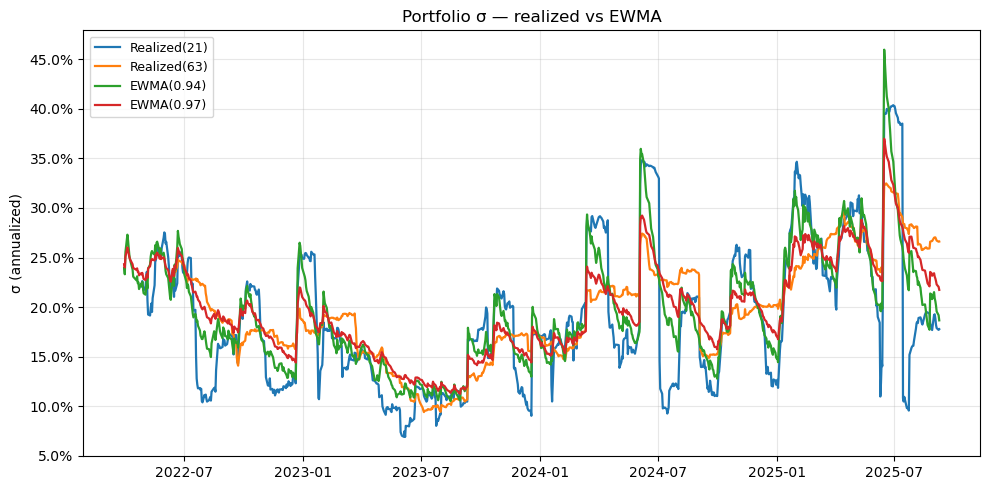

In [98]:
# --- realized & EWMA sigma (daily); compare on one axis (annualized) ---
sig21  = qrisk.realized_vol(r_port, 21)
sig63  = qrisk.realized_vol(r_port, 63)
sig252 = qrisk.realized_vol(r_port, 252)

ewma94 = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5)
ewma97 = qrisk.ewma_var_recursive(r_port, lam=0.97).pow(0.5)

qviz.plot_vol_series(
    {"Realized(21)": sig21, "Realized(63)": sig63, "EWMA(0.94)": ewma94, "EWMA(0.97)": ewma97},
    title="Portfolio σ — realized vs EWMA", annualize=True, save_path=FIG_DIR/"sigma_cmp.png"
)


In [99]:

sig21  = qrisk.realized_vol(r_port, 21)
sig63  = qrisk.realized_vol(r_port, 63)
sig252 = qrisk.realized_vol(r_port, 252)

sig_ewma_94 = qrisk.ewma_var_recursive(r_port, lam=0.94).pow(0.5)
sig_ewma_97 = qrisk.ewma_var_recursive(r_port, lam=0.97).pow(0.5)

(sig21.tail(), sig_ewma_94.tail())


(date
 2025-09-03    0.011873
 2025-09-04    0.011471
 2025-09-05    0.011270
 2025-09-08    0.011155
 2025-09-09    0.011200
 Name: PORTFOLIO, dtype: float64,
 date
 2025-09-03    0.012976
 2025-09-04    0.012700
 2025-09-05    0.012322
 2025-09-08    0.012087
 2025-09-09    0.011761
 dtype: float64)

In [100]:
#If you want the forward finite-window EWMA curves we built earlier, 
#reuse your helper and then call qviz.plot_vol_series.

In [101]:
# Future Returns (Forecasted RVol)

In [161]:
# --- 21d finite-window EWMA σ forecast for the next 20 business days ---


# r_target: choose your series — portfolio or one stock
# Example A (portfolio):
r_target = pd.read_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\portfolio_returns.pkl").sort_index()

# Example B (single stock):
# r_all = pd.read_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\log_returns_daily.pkl").sort_index()
# r_target = r_all["BAJFINANCE"]

def forward_finite_ewma_forecast(r: pd.Series, window: int, lam: float, future_days: int) -> pd.Series:
    """Forward path: for k=1..future_days, compute EWMAσ over the most-recent `window`
       returns ending at t, t-1, t-2... (so you get a 1D forecast curve plotted into the future)."""
    r = pd.Series(r).astype(float).dropna()
    w = qrisk.ewma_weights(lam, window)          # α(1..n), sums to 1
    vals = []
    n = len(r)
    for k in range(future_days):                  # k=0 uses r[n-window:n], k=1 uses r[n-1-window:n-1], etc.
        end = n - k
        start = end - window
        if start < 0: break
        block = r.iloc[start:end].values
        if np.isnan(block).any():
            vals.append(np.nan)
        else:
            vals.append(np.sqrt(np.dot(w, block[::-1]**2)))  # α(1) aligns with most-recent return
    # future business-day index
    fut_idx = pd.date_range(r.index[-1] + pd.offsets.BDay(1), periods=len(vals), freq="B")
    return pd.Series(vals[::-1], index=fut_idx)  # chronological



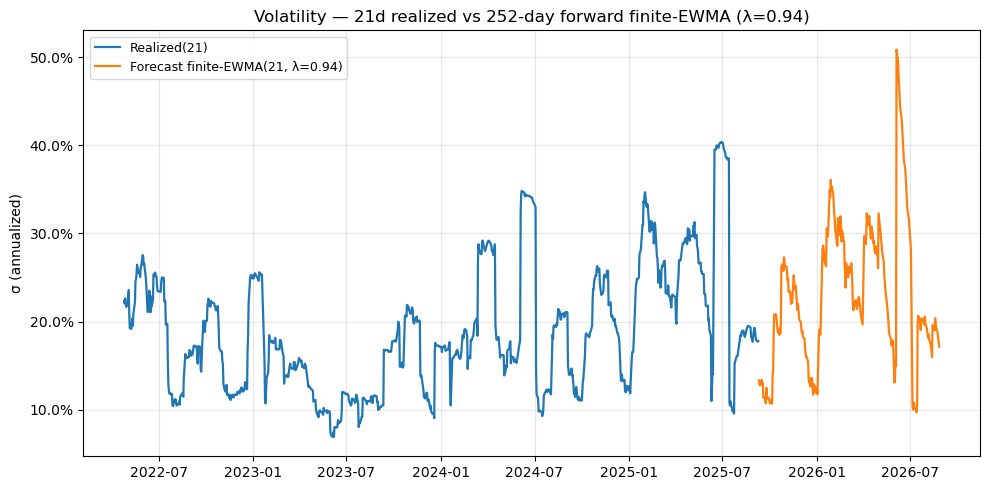

In [237]:
# ---- parameters ----
WINDOW = 21     # 21d "monthly" vol
LAMBDA = 0.94   # change to 0.97 if you prefer
FUTURE = 252     # forecast days 

# ---- plot (annualized) ----
sig_real_21 = qrisk.realized_vol(r_target, WINDOW)                    
sig_fwd_21  = forward_finite_ewma_forecast(r_target, WINDOW, LAMBDA, FUTURE)

qviz.plot_vol_series(
    {"Realized(21)": sig_real_21, f"Forecast finite-EWMA(21, λ={LAMBDA})": sig_fwd_21},
    title=f"Volatility — 21d realized vs {FUTURE}-day forward finite-EWMA (λ={LAMBDA})",
    annualize=True
)


In [238]:
# Example B (single stock):
r_all = pd.read_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\portfolio_returns.pkl").sort_index()
r_target = r_port #r_all["NEWGEN"]


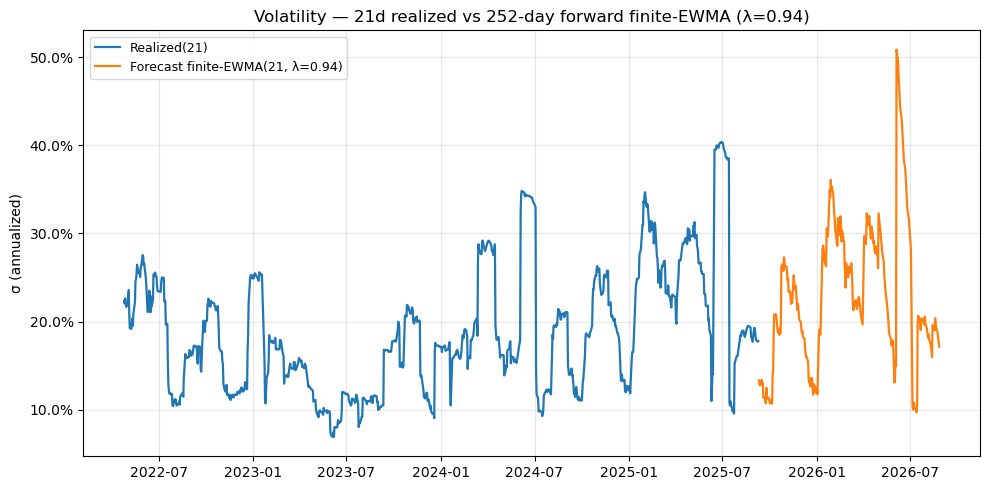

In [168]:
# ---- parameters ----
#WINDOW = 63     # 21d "monthly" vol
#LAMBDA = 0.94   # change to 0.97 if you prefer
#FUTURE = 252     # forecast days 

# ---- plot (annualized) ----
sig_real_21 = qrisk.realized_vol(r_target, WINDOW)                    
sig_fwd_21  = forward_finite_ewma_forecast(r_target, WINDOW, LAMBDA, FUTURE)

qviz.plot_vol_series(
    {"Realized(21)": sig_real_21, f"Forecast finite-EWMA(21, λ={LAMBDA})": sig_fwd_21},
    title=f"Volatility — 21d realized vs {FUTURE}-day forward finite-EWMA (λ={LAMBDA})",
    annualize=True
)


In [169]:
# GARCH + EWMA

In [170]:
# meh


# Historical realized 21d sigma
#sig_real_21 = qrisk.realized_vol(r_port, 252)    # daily units

# Forward sigma: EWMA (flat path) and GARCH(1,1) (recursive path)
#sig_fwd_ewma  = qrisk.vol_forecast_path(r_port, model="ewma",    horizon=600, lam=0.94, ewma_window=21)
#sig_fwd_garch = qrisk.vol_forecast_path(r_port, model="garch11", horizon=600)



In [239]:
r_target = pd.read_pickle(r"C:\Users\quantbase\Desktop\quant\data_int\portfolio_returns.pkl").sort_index()

In [240]:
sig_fwd_gw = qrisk.garch11_forward_like_ewma(r_target, window=WINDOW, horizon=FUTURE)


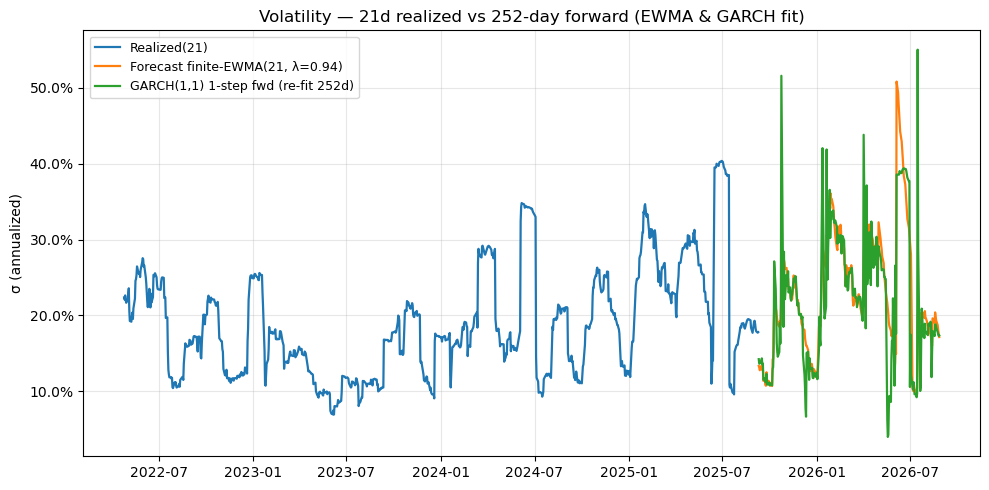

In [241]:
sig_fwd_ewma = forward_finite_ewma_forecast(r_target, window=WINDOW, lam=0.94, future_days=FUTURE)
sig_fwd_gw   = qrisk.garch11_forward_like_ewma(r_target, window=WINDOW, horizon=FUTURE)

qviz.plot_vol_series(
    {
        "Realized(21)": sig_real_21,
        "Forecast finite-EWMA(21, λ=0.94)": sig_fwd_ewma,
        f"GARCH(1,1) 1-step fwd (re-fit {GARCH_WIN}d)": sig_fwd_gw,
    },
    title=f"Volatility — 21d realized vs {FUTURE}-day forward (EWMA & GARCH fit)",
    annualize=True
)


In [217]:
sig_fwd_gw = qrisk.garch11_forward_like_ewma(r_target, window=WINDOW, horizon=FUTURE)


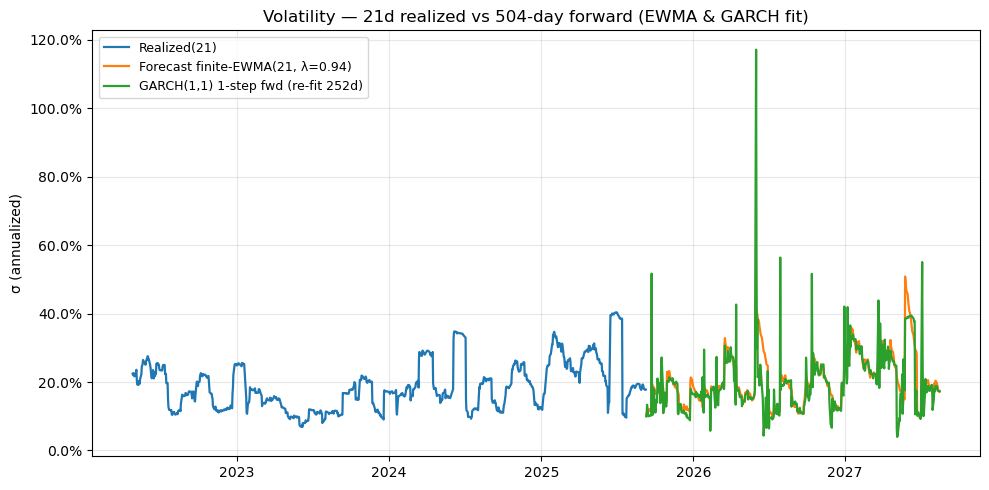

In [218]:
sig_fwd_ewma = forward_finite_ewma_forecast(r_target, window=WINDOW, lam=0.94, future_days=FUTURE)
sig_fwd_gw   = qrisk.garch11_forward_like_ewma(r_target, window=WINDOW, horizon=FUTURE)

qviz.plot_vol_series(
    {
        "Realized(21)": sig_real_21,
        "Forecast finite-EWMA(21, λ=0.94)": sig_fwd_ewma,
        f"GARCH(1,1) 1-step fwd (re-fit {GARCH_WIN}d)": sig_fwd_gw,
    },
    title=f"Volatility — 21d realized vs {FUTURE}-day forward (EWMA & GARCH fit)",
    annualize=True
)
